# Introduction
In my previous kernel, I explored deep learning with Keras on the [TwitterAirline data set](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). The model with Dropout layers produced the best results. However, it was still outperformed by the LogisticRegression model. Let's try if we can do better than the LogisticRegression with a deep learning model that uses word embeddings. 

we will:
* use the Embedding layer of Keras to create word embeddings from the training data
* use pretrained word embeddings trained on a much larger corpus

In [129]:
input_path = 'C\\Users\\Majd Mustapha\\DSP\\AirlineSentimentAnalysis\\'

# Word Embeddings
When applying one-hot encoding to the words in the tweets, we end up with sparse vectors of high dimensionality (here the number of words). On larger data sets this could cause performance issues. Additionally, one-hot encoding does not take into account the semantics of the words. For instance, *plane* and *aircraft* are different words but have a similar meaning. 

Word embeddings reduce these two issues. Word embeddings are dense vectors with a much lower dimensionality. Secondly, the semantic relationships between words are reflected in the distance and direction of the vectors.  

# Set-up of the project

In [126]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [127]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 50  # Number of dimensions of the GloVe word embeddings

In [154]:
root = Path('../')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

# Some helper functions

In [130]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

# Data Preparation
### Reading and cleaning data

In [131]:
df = pd.read_csv('data\csvfiles\kaggle_airline_dataset.csv', sep=',')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

### Train-Test split

In [132]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


### Converting words to numbers

In [135]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

### Creating word sequences of equal length
Before we can compute the word embeddings, we need to make sure the sequences are of equal length. In the example below, we truncate sequences to length MAX_LEN, or pad them with zeroes to achieve this. First, we'll have a look at the length of the (cleaned) tweets.

In [136]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    13176.000000
mean        11.168640
std          4.209335
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64

Based on the figures above we will set MAX_LEN to 24. So this means we will not be truncating any words, only pad with zeros. This is to avoid to lose information as the tweets are rather short.

In [137]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [138]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2534,
       4327,  495,  165,   21,  120,   16,   30,   74,   28, 1267, 1925,
        106,  778])

### Converting the target classes to numbers

In [139]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Splitting off validation data

In [140]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1318, 24)


# Modeling

### Training word embeddings
Keras provides an **Embedding layer** which helps us to train specific word embeddings based on our training data. It will convert the words in our vocabulary to multi-dimensional vectors. 

In [141]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(3, activation='softmax'))
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 8)             80000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 579       
Total params: 80,579
Trainable params: 80,579
Non-trainable params: 0
_________________________________________________________________


In [142]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 0s 23us/step - loss: 1.0364 - acc: 0.6084 - val_loss: 0.9926 - val_acc: 0.5986
Epoch 2/20
11858/11858 [==============================] - 0s 8us/step - loss: 0.9316 - acc: 0.6302 - val_loss: 0.9322 - val_acc: 0.5986
Epoch 3/20
11858/11858 [==============================] - 0s 8us/step - loss: 0.8719 - acc: 0.6302 - val_loss: 0.8952 - val_acc: 0.5986
Epoch 4/20
11858/11858 [==============================] - 0s 8us/step - loss: 0.8246 - acc: 0.6302 - val_loss: 0.8562 - val_acc: 0.5986
Epoch 5/20
11858/11858 [==============================] - 0s 7us/step - loss: 0.7778 - acc: 0.6333 - val_loss: 0.8188 - val_acc: 0.6093
Epoch 6/20
11858/11858 [==============================] - 0s 7us/step - loss: 0.7364 - acc: 0.6619 - val_loss: 0.7849 - val_acc: 0.6267
Epoch 7/20
11858/11858 [==============================] - 0s 7us/step - loss: 0.7002 - acc: 0.6890 - val_loss: 0.7550 - val_acc: 0.656

We have a validation accuracy of about 77%. The number of words in the tweets is rather low, so this result is rather good. 

By comparing the training and validation accuracy and loss, we see that the model starts overfitting from epoch 6..

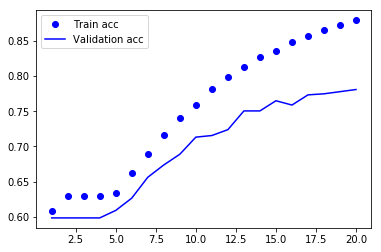

In [143]:
eval_metric(emb_history, 'acc')

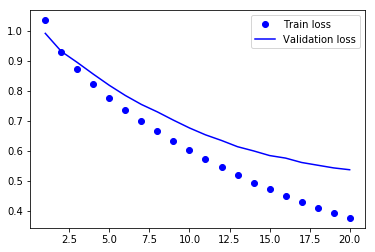

In [144]:
eval_metric(emb_history, 'loss')

In [145]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

1464/1464 [==============================] - 0s 27us/step
/n
Test accuracy of word embeddings model: 79.51%


This test result is quite ok, but still not better than the other deep learning model with Dropout layers, nor the LogisticRegression. Let's see if we can improve with pretrained word embeddings.

### Using pre-trained word embeddings
Because the training data is not so big, the model might not be able to learn good embeddings for the sentiment analysis. Luckily we can load pre-trained word embeddings built on a much larger training data. 

The [GloVe database](https://nlp.stanford.edu/projects/glove/) contains multiple pre-trained word embeddings, and more specific embeddings trained on tweets.

In [156]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
glove_dir = 'E:\\glove'
emb_dict = {}
glove = open(input_path / glove_dir / glove_file,encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
    emb_dict[word]
glove.close()

Let's test if we can find some airline related words in the dictionary.

In [112]:
airline_words = ['airplane', 'airline', 'flight', 'luggage']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word airplane in the dictionary
Found the word airline in the dictionary
Found the word flight in the dictionary
Found the word luggage in the dictionary


To feed this into an Embedding layer, we need to build a matrix containing the words in the tweets and their representative word embedding. So this matrix will be of shape (NB_WORDS, GLOVE_DIM)

In [113]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [114]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 50)            500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3603      
Total params: 503,603
Trainable params: 503,603
Non-trainable params: 0
_________________________________________________________________


With the *set_weights* method we load the pre-trained embeddings in the Embedding layer (here layer 0). By setting the *trainable* attribute to False, we make sure not to change the pre-trained embeddings.

In [115]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [116]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 0s 22us/step - loss: 0.8276 - acc: 0.6483 - val_loss: 0.7890 - val_acc: 0.6578
Epoch 2/20
11858/11858 [==============================] - 0s 13us/step - loss: 0.7201 - acc: 0.7092 - val_loss: 0.7312 - val_acc: 0.6935
Epoch 3/20
11858/11858 [==============================] - 0s 13us/step - loss: 0.6691 - acc: 0.7352 - val_loss: 0.6872 - val_acc: 0.7215
Epoch 4/20
11858/11858 [==============================] - 0s 13us/step - loss: 0.6372 - acc: 0.7478 - val_loss: 0.6602 - val_acc: 0.7291
Epoch 5/20
11858/11858 [==============================] - 0s 14us/step - loss: 0.6158 - acc: 0.7573 - val_loss: 0.6437 - val_acc: 0.7329
Epoch 6/20
11858/11858 [==============================] - 0s 17us/step - loss: 0.6000 - acc: 0.7656 - val_loss: 0.6339 - val_acc: 0.7382
Epoch 7/20
11858/11858 [==============================] - 0s 17us/step - loss: 0.5890 - acc: 0.7694 - val_loss: 0.6284 - val_acc:

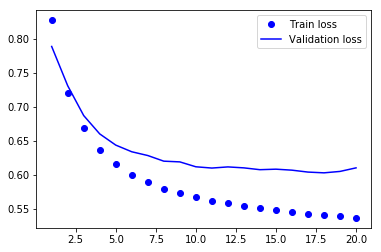

In [117]:
eval_metric(glove_history, 'loss')

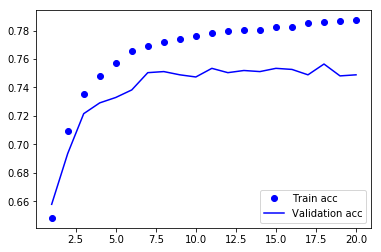

In [118]:
eval_metric(glove_history, 'acc')

In [119]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

1464/1464 [==============================] - 0s 24us/step
/n
Test accuracy of word glove model: 72.81%


The model overfits fast, after 3 epochs. Moreover the validation accuracy is lower compared to the embeddings trained on the training data. 

As a final exercise, let's see what results we get when we train the embeddings with the same number of dimensions as the GloVe data.

### Training word embeddings with more dimensions

In [120]:
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(3, activation='softmax'))
emb_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 50)            500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3603      
Total params: 503,603
Trainable params: 503,603
Non-trainable params: 0
_________________________________________________________________


In [121]:
emb_history2 = deep_model(emb_model2, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 1s 43us/step - loss: 0.9416 - acc: 0.6133 - val_loss: 0.8628 - val_acc: 0.6184
Epoch 2/20
11858/11858 [==============================] - 0s 33us/step - loss: 0.7932 - acc: 0.6450 - val_loss: 0.7748 - val_acc: 0.6457
Epoch 3/20
11858/11858 [==============================] - 0s 39us/step - loss: 0.7049 - acc: 0.6880 - val_loss: 0.7172 - val_acc: 0.7064
Epoch 4/20
11858/11858 [==============================] - 0s 40us/step - loss: 0.6308 - acc: 0.7403 - val_loss: 0.6585 - val_acc: 0.7056
Epoch 5/20
11858/11858 [==============================] - 0s 38us/step - loss: 0.5629 - acc: 0.7837 - val_loss: 0.6154 - val_acc: 0.7602
Epoch 6/20
11858/11858 [==============================] - 0s 33us/step - loss: 0.5035 - acc: 0.8232 - val_loss: 0.5832 - val_acc: 0.7610
Epoch 7/20
11858/11858 [==============================] - 0s 32us/step - loss: 0.4524 - acc: 0.8471 - val_loss: 0.5605 - val_acc:

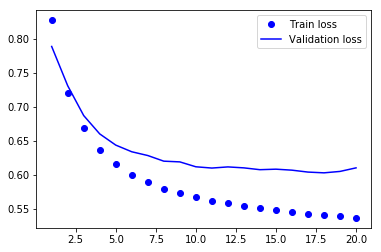

In [122]:
eval_metric(glove_history, 'loss')

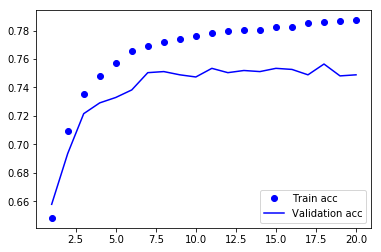

In [123]:
eval_metric(glove_history, 'acc')

In [124]:
emb_results2 = test_model(emb_model2, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word embedding model 2: {0:.2f}%'.format(emb_results2[1]*100))

1464/1464 [==============================] - 0s 41us/step
/n
Test accuracy of word embedding model 2: 77.32%


This result is very close to the model with 8-dimensional word embeddings. So there is no strong improvement. 

# Conclusion
The best result is achieved with 8-dimensional word embeddings that are trained on the available data. This even outperforms the use of word embeddings that were trained on a much larger Twitter corpus. 

Until now we have just put a Dense layer on the flattened embeddings. By doing this, we do not take into account the relationships between the words in the tweet. This can be done with a recurrent neural network or a 1D convolutional network, which I'll cover in another kernel.
